In [ ]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [63]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [64]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

In [65]:
# open csv file and load the data into pandas dataframe
df_RawSalesData = pd.read_csv('../data/raw/train.csv', parse_dates=['date'], index_col=['date'], low_memory=False)
df_RawSalesData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


In [66]:
df_RawSalesData.dtypes

store    int64
item     int64
sales    int64
dtype: object

In [67]:
df_RawSalesData.shape

(913000, 3)

In [68]:
df_RawSalesData.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [69]:
df_RawSalesData.sample(5)

,store,item,sales
date,,,
2016-12-24,10,49,49
2014-05-18,10,47,32
2015-01-12,4,19,22
2017-10-09,7,48,28
2014-05-08,3,41,26


In [70]:
df_RawSalesData.count(axis=0, numeric_only=False)

store    913000
item     913000
sales    913000
dtype: int64

In [71]:
df_RawSalesData.isnull().any().value_counts() #All 4 columns have no missing values

False    3
dtype: int64

In [72]:
#Outliers
#--------
#Next we will figure out the outliers with The interquartile range (IQR), also called the midspread or middle 50%
#It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
#IQR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier.

Q1 = df_RawSalesData.quantile(0.25)
Q3 = df_RawSalesData.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

store     5.0
item     25.0
sales    40.0
dtype: float64


In [73]:
#After computing the value of IQR, using threshhold of 1.5 * IQR away from Q1 and Q3 on both sides 
df_RawSalesDataReduced = df_RawSalesData[~((df_RawSalesData < (Q1 - 1.5 * IQR)) |(df_RawSalesData > (Q3 + 1.5 * IQR))).any(axis=1)]



In [74]:
df_RawSalesDataReduced.shape

(901033, 3)

In [75]:
df_RawSalesData.shape

(913000, 3)

In [76]:
df_SalesData = df_RawSalesData

#Next we will move on to EDA with individual features

Next, We will inspect each feature individually. We will perform the univariate and bivariate analysis using the folloiwng steps- Summary statistics Plot individually Plot against our target variable- sales. Modify the feature to make it ready for modelling, if necessary
For individual summary statistics we will use 
    .describe()
    .sample(5)
    .nunique()

Finally we will plot the feature against our target feature sales to see if and how both are related

In [157]:
def print_stats(col_name, group_by=False):
    """
    print the general statistics of the passed column
    """
    print('-'*60, '\n Individual Summary Statistics for', col_name, '\n', '-'*60)
    print('Describe \n',df_SalesData[col_name].describe(), '\n', '-'*20)
    print('Sample Observations \n',df_SalesData[col_name].sample(5), '\n', '-'*20)
    print('Number of Uniques \n',df_SalesData[col_name].nunique(), '\n', '-'*20)
    num_uniques = df_SalesData[col_name].nunique()
    if num_uniques <31: 
        print('Unique value counts \n', df_SalesData[col_name].value_counts(), '\n', '-'*20)
        
    if group_by:
        print('Group_by \n', df_SalesData.groupby('sales')[col_name].describe(), '\n','-'*20)
       
def store_analysis(store_num):
    df_store=df_SalesData.loc[df_SalesData['store'] == store_num]
    print(df_store.head())
    print('Top 5 selling items in store', store_num)
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).head())

    print('\n', 'Bottom 5 selling items in store', store_num )
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).tail())

    df_store[['sales','item']].groupby(["item"]).mean().sort_values(by='sales',ascending=False).plot.bar(width=0.2, title='store '+ str(store_num) +' item sales')
    plt.show()
    
def monthly_sales(store_num):
    
    for i in range(1, 10):
        df_store=df_SalesData.loc[df_SalesData['store'] == i]
        df_store[['sales','month']].groupby(["month"]).mean().sort_values(by='month',ascending=True).plot.bar(width=0.2, title='store '+ str(i) +' monthly sales')
        plt.show()
    
def plot_var(col_name, full_name, continuous):
    """
    plot a variable with and without sales.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name- for display purposes
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df_SalesData.loc[df_SalesData[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df_SalesData[col_name], order=sorted(df_SalesData[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of ' + full_name)

    # Plot with sales
    sns.catplot(x= col_name ,y='sales',data=df_SalesData,hue='store',kind='bar', ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('Sales')
    ax2.set_title(full_name + ' wise sales')
    plt.tight_layout()

    


1. Store

In [78]:
print_stats('store')

------------------------------------------------------------ 
 Individual Summary Statistics for store 
 ------------------------------------------------------------
Describe 
 count    913000.000000
mean          5.500000
std           2.872283
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: store, dtype: float64 
 --------------------
Sample Observations 
 date
2017-08-31    6
2016-05-17    1
2014-06-10    7
2013-12-05    3
2015-05-01    2
Name: store, dtype: int64 
 --------------------
Number of Uniques 
 10 
 --------------------
Unique value counts 
 10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64 
 --------------------


Looks like there are 10 stores in our dataset. Each store has 91300 individual sales recorded in the dataset.
The column has no missing values and no special characters etc in the data values. The values are 1-10. 
So we will not need to do any pre-processing. 
Let's move onto plotting the graphs!

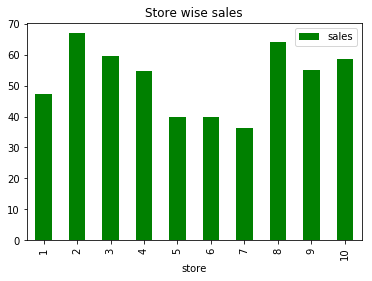

In [89]:
df_SalesData[['sales','store']].groupby(["store"]).mean().plot.bar(color='g', title='Store wise sales')
plt.show()

From the above we see that
1. Store 2 and 8 have high highest sales
2. Store 5 and 7 have lowest sales

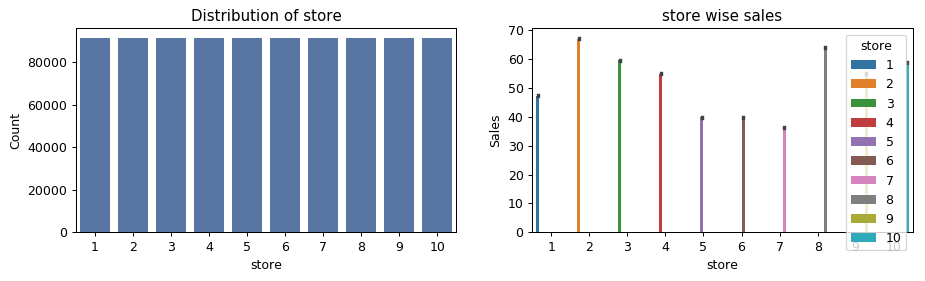

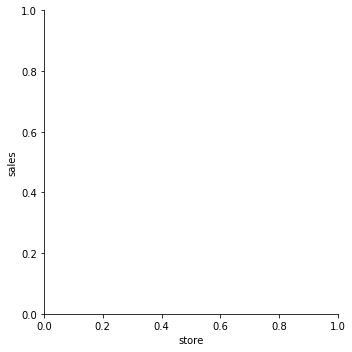

In [79]:
plot_var('store', 'store', False)

In [84]:
#let's plit the date for easier handling later
df_SalesData['day'] = df_SalesData.index.day
df_SalesData['month'] = df_SalesData.index.month
df_SalesData['year'] = df_SalesData.index.year
df_SalesData['dayofweek'] = df_SalesData.index.dayofweek

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


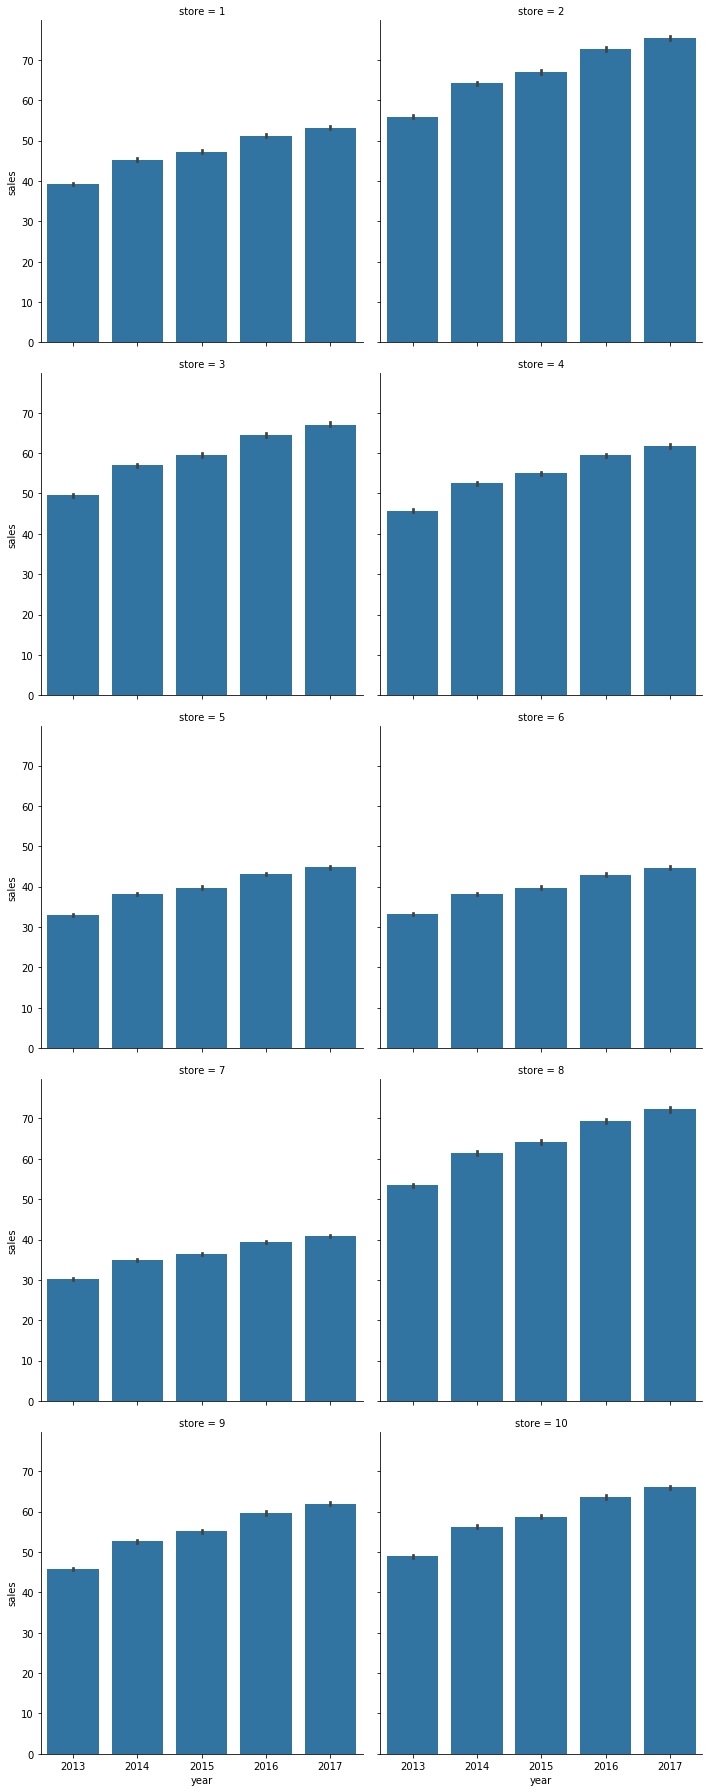

In [132]:
g=sns.FacetGrid(df_SalesData,col="store", col_order=[1,2,3,4,5,6,7,8,9,10],col_wrap=2,size=5)
g.map(sns.barplot,"year","sales")

We see there is consistent increase in sales numbers every year at all the stores!


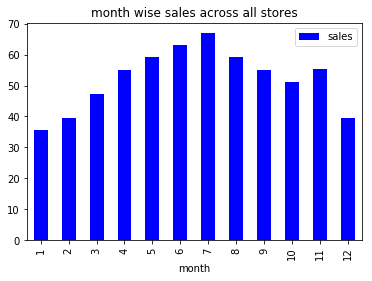

In [91]:
df_SalesData[['sales','month']].groupby(["month"]).mean().plot.bar(color='b', title='month wise sales across all stores')
plt.show()

Above plot shows there are higher sales in the month of June, July and August

2. Item

In [80]:
print_stats('item')

------------------------------------------------------------ 
 Individual Summary Statistics for item 
 ------------------------------------------------------------
Describe 
 count    913000.000000
mean         25.500000
std          14.430878
min           1.000000
25%          13.000000
50%          25.500000
75%          38.000000
max          50.000000
Name: item, dtype: float64 
 --------------------
Sample Observations 
 date
2013-01-12    30
2017-06-13    11
2013-05-17    31
2016-06-22    41
2017-03-11     4
Name: item, dtype: int64 
 --------------------
Number of Uniques 
 50 
 --------------------


In [81]:
print(sorted(df_SalesData.item.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [82]:
#It looks like there are 50 items with values 1-50

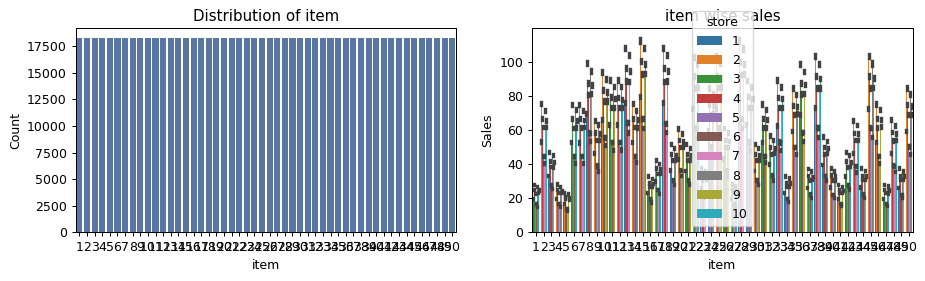

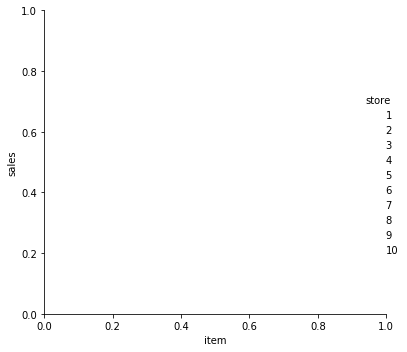

In [83]:
plot_var('item', 'item', False)

Store wise item sales Analysis
-----------------------------------


            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      1     1     13    1      1  2013          1
2013-01-02      1     1     11    2      1  2013          2
2013-01-03      1     1     14    3      1  2013          3
2013-01-04      1     1     13    4      1  2013          4
2013-01-05      1     1     10    5      1  2013          5
Top 5 selling items in store 1
------------------------------ 

          sales
item           
15    79.680723
28    79.566813
18    76.345564
13    76.159365
38    73.344469

 Bottom 5 selling items in store 1
------------------------------ 

          sales
item           
41    20.002738
1     19.971522
4     19.956188
47    19.814348
5     16.612815


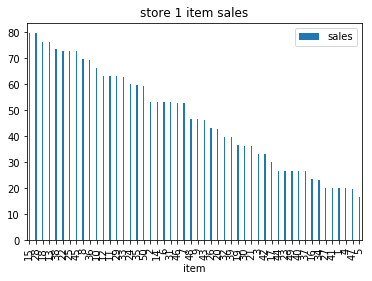

In [120]:
#Store 1:
store_analysis(1)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      2     1     12    1      1  2013          1
2013-01-02      2     1     16    2      1  2013          2
2013-01-03      2     1     16    3      1  2013          3
2013-01-04      2     1     20    4      1  2013          4
2013-01-05      2     1     16    5      1  2013          5
Top 5 selling items in store 2
------------------------------ 

           sales
item            
28    112.638007
15    112.578861
18    108.117196
13    107.903067
25    103.426068

 Bottom 5 selling items in store 2
------------------------------ 

          sales
item           
4     28.234940
47    28.187842
1     28.173604
41    28.069551
5     23.540526


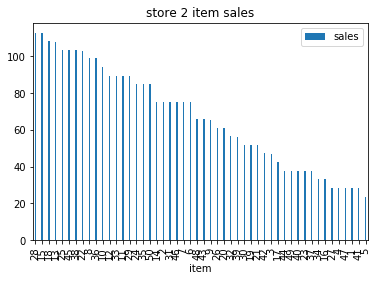

In [121]:
#Store 2:
store_analysis(2)


            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      3     1     19    1      1  2013          1
2013-01-02      3     1      8    2      1  2013          2
2013-01-03      3     1     10    3      1  2013          3
2013-01-04      3     1     15    4      1  2013          4
2013-01-05      3     1     22    5      1  2013          5
Top 5 selling items in store 3
------------------------------ 

           sales
item            
15    100.423330
28    100.143483
13     96.214677
18     96.090909
38     91.871851

 Bottom 5 selling items in store 3
------------------------------ 

          sales
item           
4     25.116101
27    25.090909
1     25.070099
41    24.989047
5     20.857612


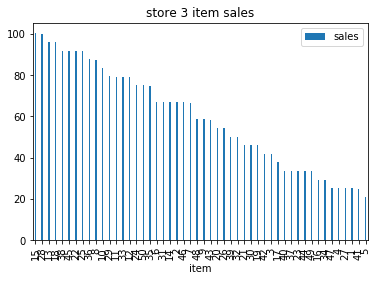

In [122]:
#Store 3:
store_analysis(3)


Interesting pattern emerging so far is the most and least sold items are more or less same for these all stores.
Let's see if the pattern continues for the restr of the stores

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      4     1     10    1      1  2013          1
2013-01-02      4     1     12    2      1  2013          2
2013-01-03      4     1      8    3      1  2013          3
2013-01-04      4     1     15    4      1  2013          4
2013-01-05      4     1     19    5      1  2013          5
Top 5 selling items in store 4
------------------------------ 

          sales
item           
15    92.653888
28    92.552574
13    88.604600
18    88.501643
25    85.022453

 Bottom 5 selling items in store 4
------------------------------ 

          sales
item           
47    23.114458
27    23.111720
4     23.086528
1     22.938664
5     19.525192


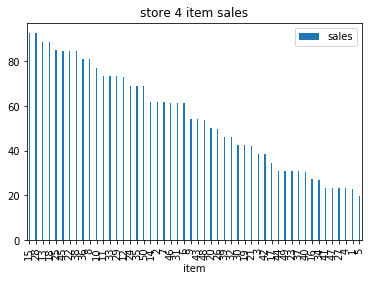

In [123]:
#Store 4:
store_analysis(4)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      5     1     11    1      1  2013          1
2013-01-02      5     1      9    2      1  2013          2
2013-01-03      5     1     12    3      1  2013          3
2013-01-04      5     1      8    4      1  2013          4
2013-01-05      5     1     13    5      1  2013          5
Top 5 selling items in store 5
------------------------------ 

          sales
item           
15    66.987404
28    66.980832
13    64.395947
18    64.080504
45    61.427163

 Bottom 5 selling items in store 5
------------------------------ 

          sales
item           
4     16.776561
27    16.763417
1     16.739321
47    16.699343
5     14.086528


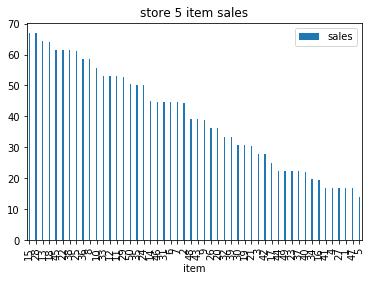

In [124]:
#Store 5:
store_analysis(5)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      6     1     20    1      1  2013          1
2013-01-02      6     1      6    2      1  2013          2
2013-01-03      6     1     11    3      1  2013          3
2013-01-04      6     1      7    4      1  2013          4
2013-01-05      6     1     12    5      1  2013          5
Top 5 selling items in store 6
------------------------------ 

          sales
item           
15    66.668675
28    66.460570
13    64.324754
18    63.725630
25    61.364184

 Bottom 5 selling items in store 6
------------------------------ 

          sales
item           
4     16.754107
1     16.717963
47    16.708653
41    16.607338
5     13.893209


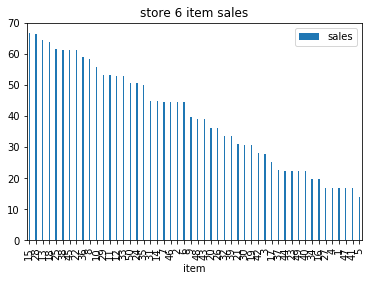

In [125]:
#Store 6:
store_analysis(6)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      7     1      7    1      1  2013          1
2013-01-02      7     1      4    2      1  2013          2
2013-01-03      7     1      8    3      1  2013          3
2013-01-04      7     1      7    4      1  2013          4
2013-01-05      7     1      8    5      1  2013          5
Top 5 selling items in store 7
------------------------------ 

          sales
item           
15    61.139102
28    61.104053
18    58.745893
13    58.547645
25    56.398686

 Bottom 5 selling items in store 7
------------------------------ 

          sales
item           
41    15.471522
4     15.358160
27    15.213582
1     15.159365
5     12.733844


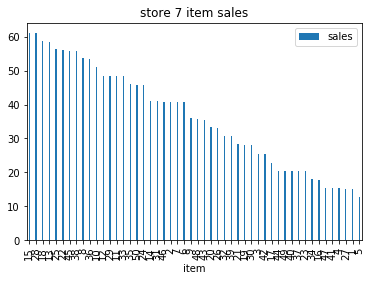

In [126]:
#Store 7:
store_analysis(7)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      8     1     16    1      1  2013          1
2013-01-02      8     1     10    2      1  2013          2
2013-01-03      8     1     12    3      1  2013          3
2013-01-04      8     1     21    4      1  2013          4
2013-01-05      8     1     15    5      1  2013          5
Top 5 selling items in store 8
------------------------------ 

           sales
item            
15    108.047645
28    107.813253
18    103.820372
13    103.819825
25     99.244797

 Bottom 5 selling items in store 8
------------------------------ 

          sales
item           
27    27.044359
41    27.036145
1     26.983571
4     26.948521
5     22.427711


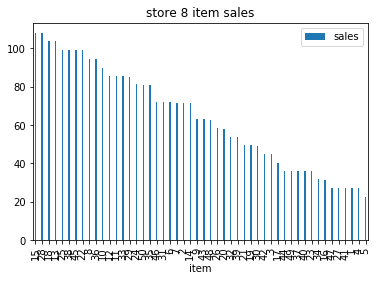

In [127]:
#Store 8:
store_analysis(8)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01      9     1     11    1      1  2013          1
2013-01-02      9     1      9    2      1  2013          2
2013-01-03      9     1     20    3      1  2013          3
2013-01-04      9     1     22    4      1  2013          4
2013-01-05      9     1     22    5      1  2013          5
Top 5 selling items in store 9
------------------------------ 

          sales
item           
15    93.137459
28    92.787514
18    88.610624
13    88.511501
25    85.136911

 Bottom 5 selling items in store 9
------------------------------ 

          sales
item           
1     23.325849
41    23.191128
4     23.150055
47    23.003286
5     19.272180


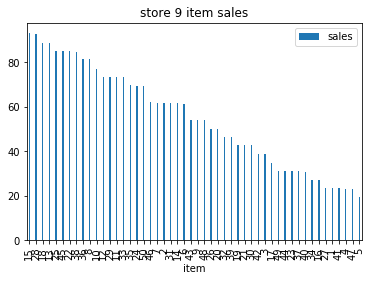

In [128]:
#Store 9:
store_analysis(9)

            store  item  sales  day  month  year  dayofweek
date                                                       
2013-01-01     10     1     14    1      1  2013          1
2013-01-02     10     1     14    2      1  2013          2
2013-01-03     10     1     16    3      1  2013          3
2013-01-04     10     1     17    4      1  2013          4
2013-01-05     10     1     12    5      1  2013          5
Top 5 selling items in store 10
------------------------------ 

          sales
item           
15    98.990690
28    98.766156
18    94.719606
13    94.684556
45    90.690581

 Bottom 5 selling items in store 10
------------------------------ 

          sales
item           
1     24.736035
4     24.721249
27    24.701533
41    24.654984
5     20.637459


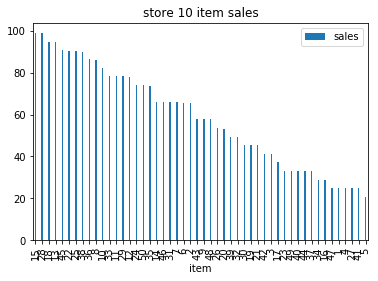

In [129]:
#Store 10:
store_analysis(10)

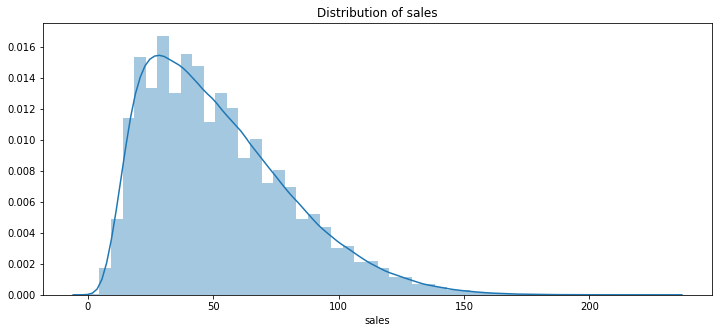

In [135]:
#Let's look at our target variable - sales
plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(df_SalesData['sales'])

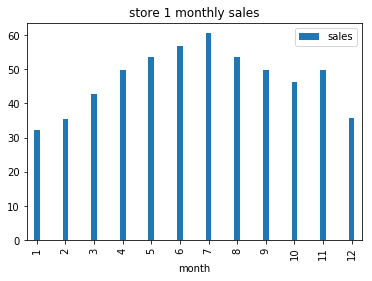

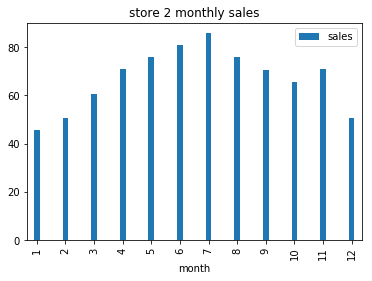

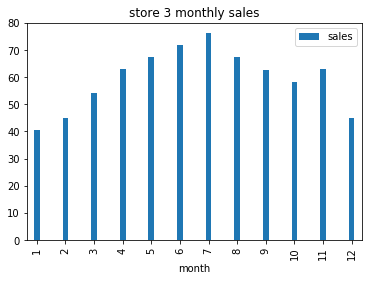

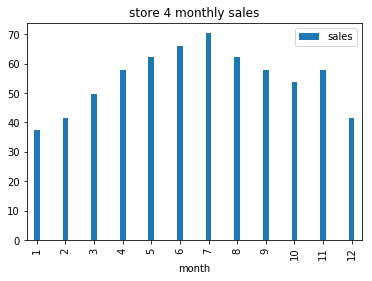

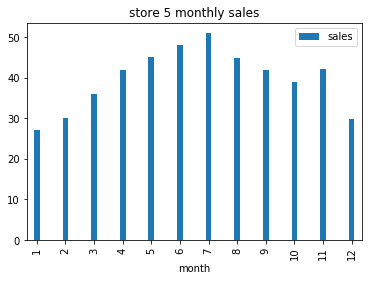

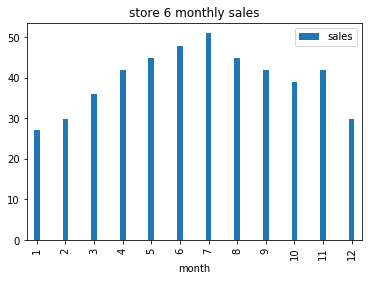

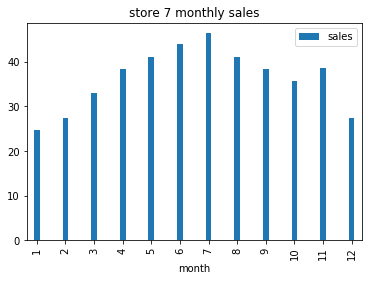

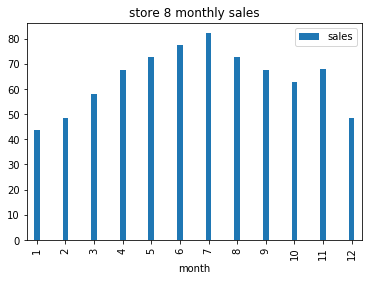

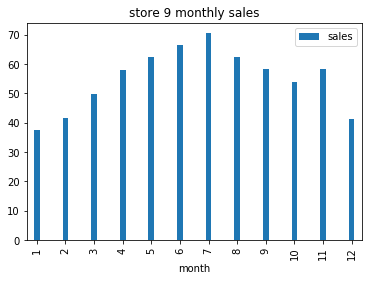

In [158]:
#let's plot monthly sales for each store, 
#that way we could comapre and see if the sales trends are similar across stores
monthly_sales(1)